#### Install dditional libraries ##########

In [1]:
%%capture
!pip install optuna
!pip install shap
!pip install hyperopt
!pip install imbalanced-learn
!pip install awswrangler
!pip install lightgbm

In [2]:
%%capture
!pip install xgboost
!pip install catboost
!pip install tune-sklearn ray[tune]
!pip install pycaret
!pip install scikit-optimize
!pip install yellowbrick

In [1]:
# import torch
# # If there"s a GPU available...
# if torch.cuda.is_available():    
#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda")
#     print("There are %d GPU(s) available." % torch.cuda.device_count())
#     print("We will use the GPU:", torch.cuda.get_device_name(0))
# # If not...
# else:
#     print("No GPU available, using the CPU instead.")
#     device = torch.device("cpu")

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from datetime import datetime, date, timedelta
import datetime as dt
import os
import math
import warnings 
import time
import pickle
import boto3
from io import BytesIO
import re
import awswrangler as wr
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import warnings
import seaborn as sns

#from pandas_profiling import ProfileReport
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

Matplotlib is building the font cache; this may take a moment.


In [2]:
import optuna, shap
from hyperopt import tpe, hp, fmin
import hyperopt
import pycaret
import lightgbm
# pycaret.__version__

In [12]:
import multiprocessing
import os

print(multiprocessing.cpu_count())
# print(os.cpu_count())

96


In [4]:
import xgboost

In [5]:
xgboost.__version__

'1.5.0'

In [6]:
import time
start_time = time.time()
from io import BytesIO


df = wr.s3.read_csv("s3://daan888/projectcr/data/training/mortgage_risk_unique_training_data.csv", skip_blank_lines=True)

df.reset_index(drop=True, inplace=True)

### clean columns names

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print("--- %s seconds ---" % (time.time() - start_time))  

--- 0.5951483249664307 seconds ---


In [13]:
df.shape

(43685, 9)

In [14]:
df.columns

Index(['default', 'balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'fico_orig_time', 'ltv_orig_time', 'uer_time'],
      dtype='object')

In [15]:
missing_count = df.isnull().sum() # the count of missing values
value_count = df.isnull().count() # the count of all values 
missing_percentage = round(missing_count / value_count * 100,2) #the percentage of missing values
missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage}) #create a dataframe
print(missing_df)

                    count  percentage
default                 0         0.0
balance_time            0         0.0
ltv_time                0         0.0
interest_rate_time      0         0.0
hpi_time                0         0.0
gdp_time                0         0.0
fico_orig_time          0         0.0
ltv_orig_time           0         0.0
uer_time                0         0.0


In [16]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',150,'display.max_columns',50):
              display(df.head(2))

default  balance_time   ltv_time  interest_rate_time  hpi_time  gdp_time  \
0        1      29087.21  26.658065                9.20    146.45  2.715903   
1        0     105654.77  65.469851                7.68    225.10  2.151365   

   fico_orig_time  ltv_orig_time  uer_time  
0             715           69.4       8.3  
1             558           80.0       4.7

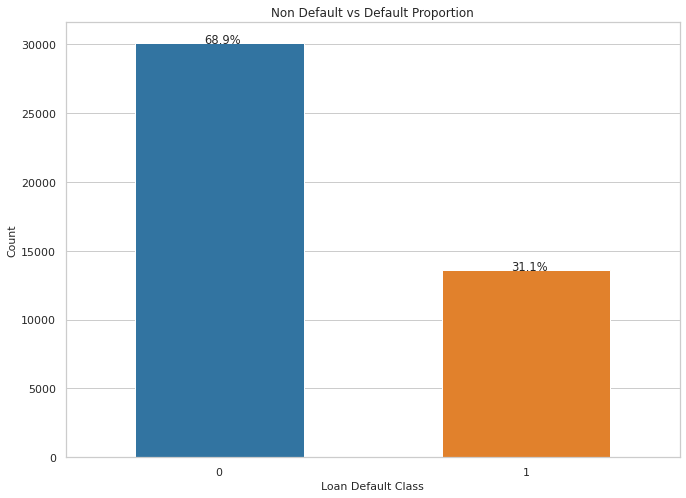

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(11,8))

color_labels = df['default'].unique()

# List of color palette to use
rgb_values = sns.color_palette("tab10", 2)

# Map label to color palette

color_map = dict(zip(color_labels, rgb_values))


ax = sns.countplot(x="default", data=df,palette=df['default'].map(color_map))

plt.xticks(size=11)
plt.xlabel('Loan Default Class', size=  11)
plt.yticks(size=11)
plt.ylabel('Count', size=  11)

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 11.5)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .55)

without_hue(ax, df.default)
plt.title('Non Default vs Default Proportion')
plt.show()

In [18]:
##### subset for test unseen after val

In [19]:
## Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   

In [20]:
df, data_unseen = data_sampling(df, 0.9, 101)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 4369 samples for Unseen Data.


In [21]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',150,'display.max_columns',50):
              display(df.head(2))

default  balance_time    ltv_time  interest_rate_time  hpi_time  gdp_time  \
0        1      275430.0  103.259302                 9.0    173.35 -0.314448   
1        1      208587.7  117.794474                 5.0    158.77 -3.339549   

   fico_orig_time  ltv_orig_time  uer_time  
0             665           80.0       5.8  
1             733           80.0       9.5

In [22]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',150,'display.max_columns',50):
              display(data_unseen.head(2))

default  balance_time   ltv_time  interest_rate_time  hpi_time  gdp_time  \
0        1     165955.21  63.422200              11.255    217.37  1.692969   
1        0      79980.24  52.849376               6.305    226.29  2.899137   

   fico_orig_time  ltv_orig_time  uer_time  
0             582           75.0       4.5  
1             550           65.0       4.7

In [23]:
df.shape

(39316, 9)

In [24]:
data_unseen.shape

(4369, 9)

In [25]:
df.default.value_counts(normalize=True)

0    0.688854
1    0.311146
Name: default, dtype: float64

In [26]:
data_unseen.default.value_counts(normalize=True)

0    0.687572
1    0.312428
Name: default, dtype: float64

In [27]:
############ HPO Model first ###########

In [28]:
#### Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from yellowbrick.model_selection import cv_scores
from yellowbrick.model_selection import CVScores

In [29]:
df.columns

Index(['default', 'balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time',
       'gdp_time', 'fico_orig_time', 'ltv_orig_time', 'uer_time'],
      dtype='object')

In [30]:
data_unseen.drop(columns=['default']).head(2)

balance_time   ltv_time  interest_rate_time  hpi_time  gdp_time  \
0     165955.21  63.422200              11.255    217.37  1.692969   
1      79980.24  52.849376               6.305    226.29  2.899137   

   fico_orig_time  ltv_orig_time  uer_time  
0             582           75.0       4.5  
1             550           65.0       4.7

In [31]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['default']), 
                                                    df['default'], 
                                                    test_size=.20, 
                                                    random_state=101,
                                                    shuffle=True,
                                                   stratify=df['default'])

# Define categorical columns
categorical = list(X_train.select_dtypes(['category','O']).columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: []
Numerical columns are: ['balance_time', 'ltv_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'fico_orig_time', 'ltv_orig_time', 'uer_time']


###### Naive Bayes Implementation

In [26]:
# train a Gaussian Naive Bayes classifier on the training set with cross validation
from sklearn.naive_bayes import GaussianNB


# instantiate the model
gnb = GaussianNB()



In [27]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=201)

Started at  2021-11-05 18:29:39.781626


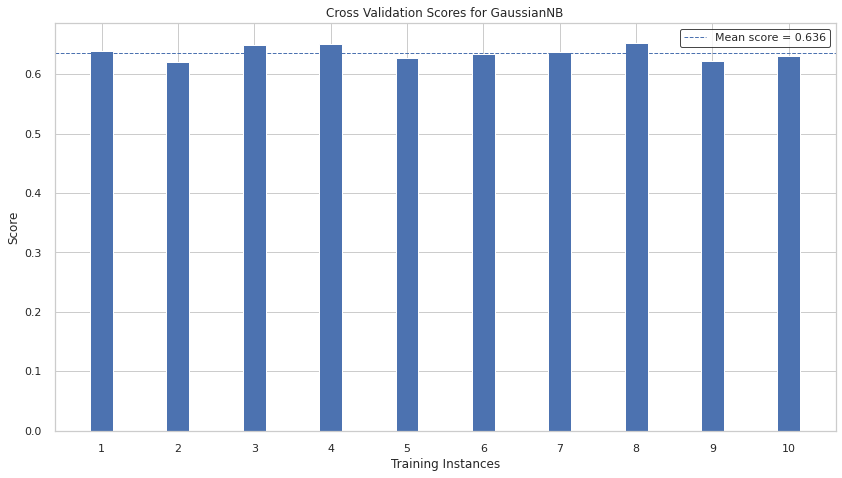

It took: 0.0 minutes.


In [79]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

# Fit the data to the visualizer
visualizer = cv_scores(gnb, X_train,y_train, cv=cv, scoring='f1',n_jobs=-1, seed=123)



end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

In [80]:
visualizer

CVScores(ax=<AxesSubplot:title={'center':'Cross Validation Scores for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>,
         cv=StratifiedKFold(n_splits=10, random_state=201, shuffle=False),
         estimator=GaussianNB(), scoring='f1')

In [81]:
modelnb = gnb.fit(X_train, y_train)

In [82]:
modelnb

GaussianNB()

In [83]:
# predict the target on the test dataset
predict_test = modelnb.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.7915818921668362


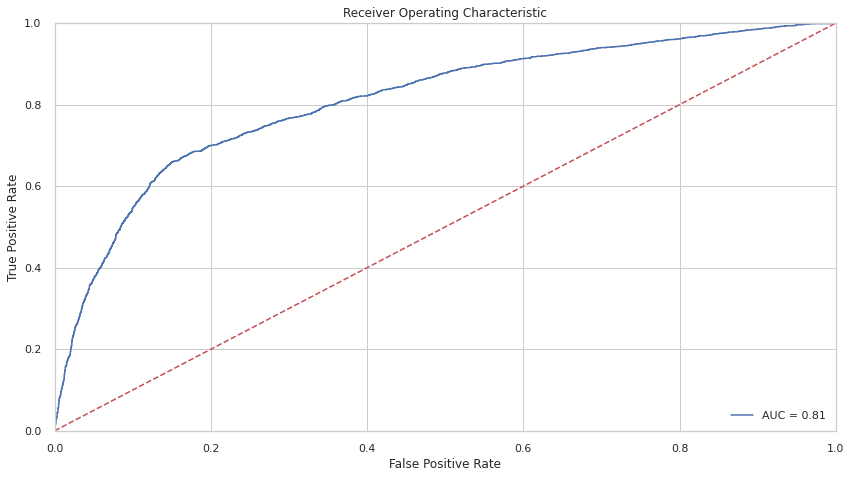

In [84]:
from sklearn.metrics import roc_curve, auc

probs               = modelnb.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      5417
           1       0.69      0.59      0.64      2447

    accuracy                           0.79      7864
   macro avg       0.76      0.74      0.75      7864
weighted avg       0.79      0.79      0.79      7864



In [86]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.640


In [87]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.594


In [88]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.692


In [89]:
print('accuracy_score on validation dataset : ', accuracy_test)

accuracy_score on validation dataset :  0.7915818921668362


In [91]:
conf_matrixnb0 = confusion_matrix(y_test,predict_test)

In [37]:
##### Not very good

In [38]:
##### Hyperparameter Tuning to improve recall f1

In [39]:
#  np.logspace(0,-20, num=500)

In [113]:
param_grid_nb = {
    'var_smoothing':  np.logspace(0,-30, num=1000)  # Calculation Stability to Widen (or Smooth) the Curve
}

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [115]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, 
                    cv=StratifiedKFold(n_splits=10), n_jobs=-1, scoring='f1')

nbModel_grid.fit(X_train, y_train)

print(nbModel_grid.best_score_)
print(nbModel_grid.best_estimator_)


end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

Started at  2021-11-05 18:36:44.395685
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 3216 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 4516 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 6016 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 7716 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 9616 tasks      | elapsed:   33.9s


0.6367843496056059
GaussianNB(var_smoothing=9.140310748756223e-10)
It took: 0.5833333333333334 minutes.


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   35.2s finished


In [116]:
# summarize result
print('Best Score: %s' % nbModel_grid.best_score_)
print('Best Hyperparameters: %s' % nbModel_grid.best_params_)

Best Score: 0.6367843496056059
Best Hyperparameters: {'var_smoothing': 9.140310748756223e-10}


In [117]:
nbModel_grid

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 9.33189772e-01, 8.70843150e-01, 8.12661920e-01,
       7.58367791e-01, 7.07701066e-01, 6.60419396e-01, 6.16296626e-01,
       5.75121707e-01, 5.36697695e-01, 5.00840799e-01, 4.67379511e-01,
       4.36153779e-01, 4.07014245...
       4.90558371e-30, 4.57784054e-30, 4.27199397e-30, 3.98658107e-30,
       3.72023668e-30, 3.47168682e-30, 3.23974263e-30, 3.02329468e-30,
       2.82130768e-30, 2.63281547e-30, 2.45691646e-30, 2.29276931e-30,
       2.13958887e-30, 1.99664245e-30, 1.86324631e-30, 1.73876240e-30,
       1.62259529e-30, 1.51418933e-30, 1.41302599e-30, 1.31862140e-30,
       1.23052400e-30, 1.14831241e-30, 1.07159340e-30, 1.00000000e-30])},
             scoring='f1', verbose=1)

In [118]:
predict_test=  nbModel_grid.predict(X_test)

In [119]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      5417
           1       0.69      0.59      0.64      2447

    accuracy                           0.79      7864
   macro avg       0.76      0.74      0.75      7864
weighted avg       0.79      0.79      0.79      7864



In [120]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.639


In [121]:
print('Recall validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall validation dataset: 0.594


In [122]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.693


In [123]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.737


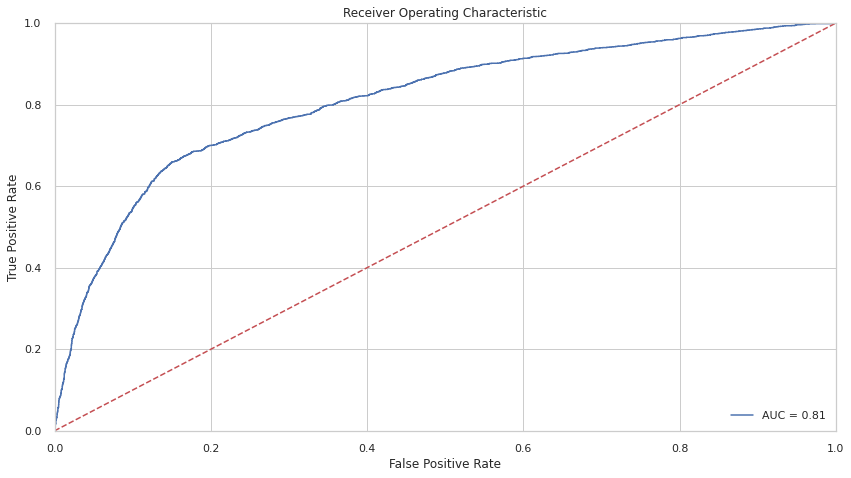

In [125]:
from sklearn.metrics import roc_curve, auc

probs               = nbModel_grid.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [169]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [128]:
conf_matrixnb01 = confusion_matrix(y_test,predict_test)

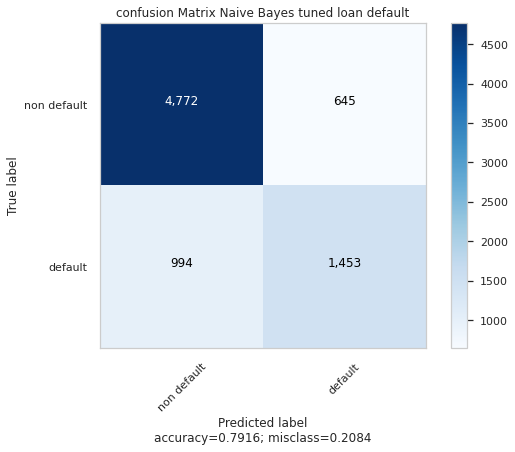

In [129]:
plot_confusion_matrix(cm           = conf_matrixnb01,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "confusion Matrix Naive Bayes tuned loan default")

In [51]:
y_test.unique()

array([0, 1])

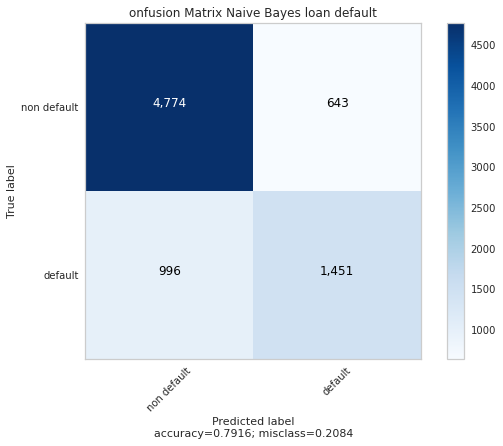

In [52]:
plot_confusion_matrix(cm           = conf_matrixnb,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "onfusion Matrix Naive Bayes loan default")

##### We did not achieved any improvements on this model max F1 Score: 0.624

##### Predict unseen data

In [130]:
data_unseen_prednb  = nbModel_grid.predict(data_unseen.drop(columns=['default']))

In [131]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      5417
           1       0.69      0.59      0.64      2447

    accuracy                           0.79      7864
   macro avg       0.76      0.74      0.75      7864
weighted avg       0.79      0.79      0.79      7864



In [136]:
# Accuracy Score on unssen  dataset
accuracy_unseen = accuracy_score(data_unseen['default'],data_unseen_prednb)

print('accuracy_score on unseen dataset : ', accuracy_unseen)

print('F1 Score on unseen dataset : %.3f' % f1_score(data_unseen['default'],data_unseen_prednb))

print('Recall on unseen dataset: %.3f' % recall_score(data_unseen['default'],data_unseen_prednb))

print('Precision on unseen dataset: %.3f' % precision_score(data_unseen['default'],data_unseen_prednb))

print('roc auc score unseen dataset: %.3f' % roc_auc_score(data_unseen['default'],data_unseen_prednb))

accuracy_score on unseen dataset :  0.7912565804531929
F1 Score on unseen dataset : 0.631
Recall on unseen dataset: 0.572
roc auc score unseen dataset: 0.731


In [ ]:
conf_matrixnb01 = confusion_matrix(y_test,predict_test)

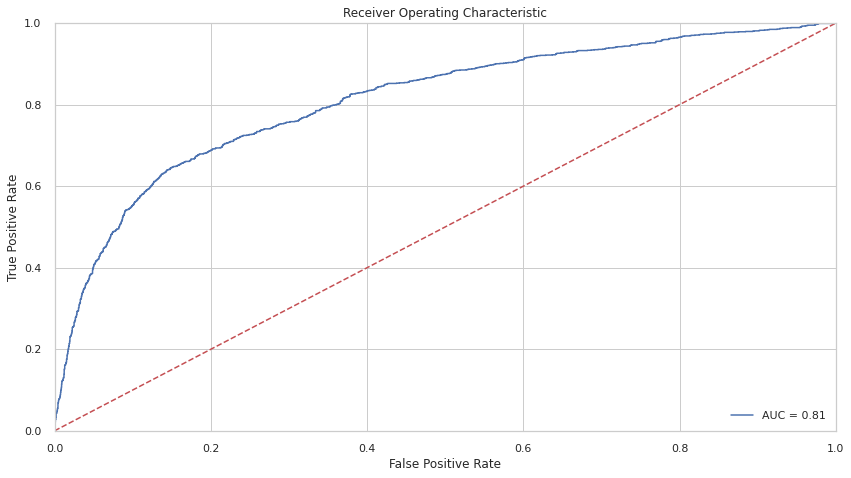

In [134]:
from sklearn.metrics import roc_curve, auc

probs1               = nbModel_grid.predict_proba(data_unseen.drop(columns=['default']))
preds1               = probs1[:,1]
fpr, tpr, threshold = roc_curve(data_unseen['default'], preds1)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Random forest model now

In [98]:
from sklearn.ensemble import RandomForestClassifier



In [69]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5,
                               min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)

In [28]:
from pprint import pprint
print('Final Model Parameters:\n')
pprint(rf.get_params())

Final Model Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [29]:
#### Randomforestclassifier  baseline with no hyperparameter tuning

In [30]:
# # Partition data
# X_train, X_test, y_train, y_test 

In [31]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=202)

Started at  2021-11-06 13:53:09.677473


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


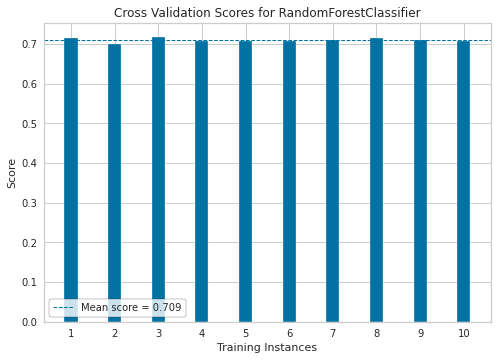

It took: 1.0 minutes.


In [32]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

# Fit the data to the visualizer
visualizer = cv_scores(rf, X_train,y_train, cv=cv, scoring='f1',n_jobs=-1, seed=123)



end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

In [41]:
import datetime
start = datetime.datetime.now()

rf.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

It took: 0.08333333333333333 minutes.


In [42]:
# predict the target on the test dataset
predict_test = rf.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8259155645981688


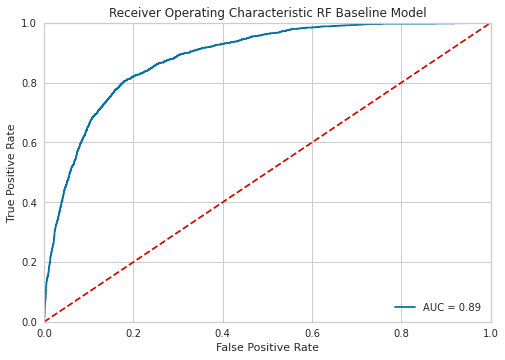

In [49]:
from sklearn.metrics import roc_curve, auc

probs               =  rf.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic RF Baseline Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      5417
           1       0.73      0.69      0.71      2447

    accuracy                           0.83      7864
   macro avg       0.80      0.79      0.79      7864
weighted avg       0.82      0.83      0.82      7864



In [45]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.712


In [46]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.692


In [47]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.734


In [48]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.789


In [71]:
y_test.unique()

array([0, 1])

In [72]:
y_test.value_counts()

0    5417
1    2447
Name: default, dtype: int64

In [51]:
conf_matrixrfv1 = confusion_matrix(y_test,predict_test)

In [53]:
conf_matrixrfv1

array([[4802,  615],
       [ 754, 1693]])

In [75]:
3815+514

4329

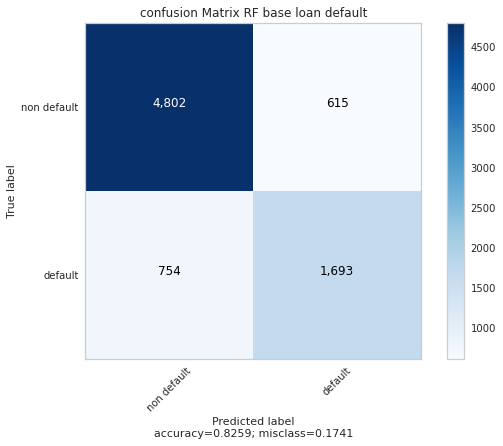

In [54]:
plot_confusion_matrix(cm           = conf_matrixrfv1,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "confusion Matrix RF base loan default")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


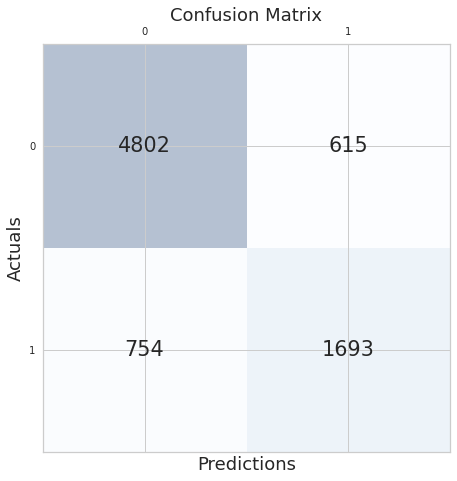

In [79]:
conf_matrix = confusion_matrix(y_test,predict_test)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap='Blues', alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

<AxesSubplot:>

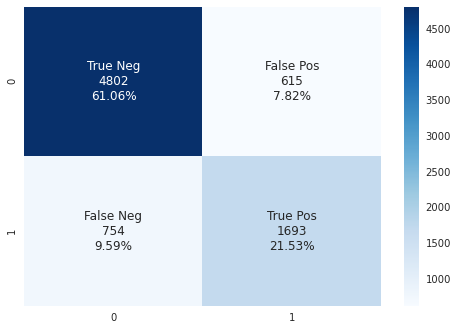

In [80]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

In [81]:
1369 / (1369 + 593)

0.6977573904179408

In [82]:
y_test.value_counts()

0    5417
1    2447
Name: default, dtype: int64

######  Improve our RF Baseline model

In [89]:
from tune_sklearn import TuneSearchCV
from tune_sklearn import TuneGridSearchCV
from ray import tune

In [90]:
from scipy.stats import randint

In [91]:
# Number of trees in random forest
[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [92]:
randint(20, 500)

In [93]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,50)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [94]:
param_grid['class_weight']

[{0: 0.0, 1: 1.0},
 {0: 0.02020408163265306, 1: 0.9797959183673469},
 {0: 0.04040816326530612, 1: 0.9595918367346938},
 {0: 0.06061224489795918, 1: 0.9393877551020409},
 {0: 0.08081632653061224, 1: 0.9191836734693878},
 {0: 0.1010204081632653, 1: 0.8989795918367347},
 {0: 0.12122448979591836, 1: 0.8787755102040816},
 {0: 0.14142857142857143, 1: 0.8585714285714285},
 {0: 0.16163265306122448, 1: 0.8383673469387756},
 {0: 0.18183673469387754, 1: 0.8181632653061225},
 {0: 0.2020408163265306, 1: 0.7979591836734694},
 {0: 0.22224489795918367, 1: 0.7777551020408163},
 {0: 0.24244897959183673, 1: 0.7575510204081632},
 {0: 0.2626530612244898, 1: 0.7373469387755103},
 {0: 0.28285714285714286, 1: 0.7171428571428571},
 {0: 0.3030612244897959, 1: 0.6969387755102041},
 {0: 0.32326530612244897, 1: 0.676734693877551},
 {0: 0.34346938775510205, 1: 0.656530612244898},
 {0: 0.3636734693877551, 1: 0.636326530612245},
 {0: 0.38387755102040816, 1: 0.6161224489795918},
 {0: 0.4040816326530612, 1: 0.595918367

In [95]:
[{0: w} for w in [1, 2, 4, 6, 10]]

[{0: 1}, {0: 2}, {0: 4}, {0: 6}, {0: 10}]

In [96]:
param_distributions = {
    "n_estimators": tune.randint(20, 3000),
    "max_depth": tune.randint(1, 35),
    "min_samples_split": tune.randint(2, 15),
     "min_samples_leaf" : tune.randint(1, 8),
    # Method of selecting samples for training each tree
    "bootstrap" : [True, False],
    "max_features": ['auto', 'sqrt', 'log2'],
    "criterion": ['entropy', 'gini'],
    "class_weight": ["balanced", "balanced_subsample"]
    
    
}


In [99]:
rf2 = RandomForestClassifier(random_state=999)

In [101]:
rf_credit_risk_init = TuneSearchCV(
    rf2,
param_distributions,
    n_trials=10,
#     search_optimization="bayesian",
    scoring=( "f1"),
    refit="f1",
    max_iters=300)

In [102]:
rf_credit_risk_init

TuneSearchCV(estimator=RandomForestClassifier(random_state=999),
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger'>],
             mode='max', n_jobs=-1,
             param_distributions={'bootstrap': [True, False],
                                  'class_weight': ['balanced',
                                                   'balanced_subsample'],
                                  'criterion': ['entropy', 'gini'],
                                  'max_depth': <ray.tune.sample.Integer object at 0x7fc2a5b48550>,
                                  'max_features': ['auto', 'sqrt', 'log2'],
                                  'min_samples_leaf': <ray.tune.sample.Integer object at 0x7fc2a5b48780>,
                                  'min_samples_split': <ray.tune.sample.Integer object at 0x7fc2a5b484e0>,
                                  'n_estimators': <ray.tune.sample.Integer object at 0x7fc2a5b65a90>},
             refit='f

In [103]:
import datetime
start = datetime.datetime.now()

rf_credit_risk_init.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

It took: 10.533333333333333 minutes.


In [104]:
#credit_risk.cv_results_

print(rf_credit_risk_init.best_params_)

print('------------')


print(rf_credit_risk_init.best_score_)


print('------------')


print(rf_credit_risk_init.best_estimator_)

{'n_estimators': 572, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': 'balanced'}
------------
0.7294692529834903
------------
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=14, n_estimators=572,
                       random_state=999)


In [120]:
# summarize results

print('Best Hyperparameters: %s' % rf_credit_risk_init.best_params_)

print('------------')


print('Best Score: %s' % rf_credit_risk_init.best_score_)

Best Hyperparameters: {'n_estimators': 572, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': 'balanced'}
------------
Best Score: 0.7294692529834903


In [121]:
# predict the target on the test dataset
predict_test = rf_credit_risk_init.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on validation dataset : ', accuracy_test)

accuracy_score on validation dataset :  0.8170142421159715


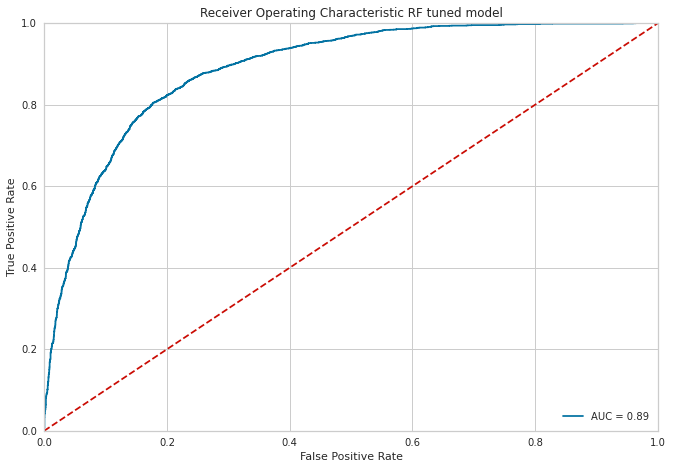

In [122]:
from sklearn.metrics import roc_curve, auc
plt.figure( figsize =(11, 7.5))
probsrf               =  rf_credit_risk_init.predict_proba(X_test)
predsrf               = probsrf[:,1]
fpr, tpr, threshold = roc_curve(y_test, predsrf)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic RF tuned model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [123]:
##### Classification Report


print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5417
           1       0.67      0.80      0.73      2447

    accuracy                           0.82      7864
   macro avg       0.79      0.81      0.80      7864
weighted avg       0.83      0.82      0.82      7864



In [124]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.731


In [125]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.674


In [126]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.799


In [127]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.812


In [100]:
conf_matrixnrftuned = confusion_matrix(y_test,predict_test)

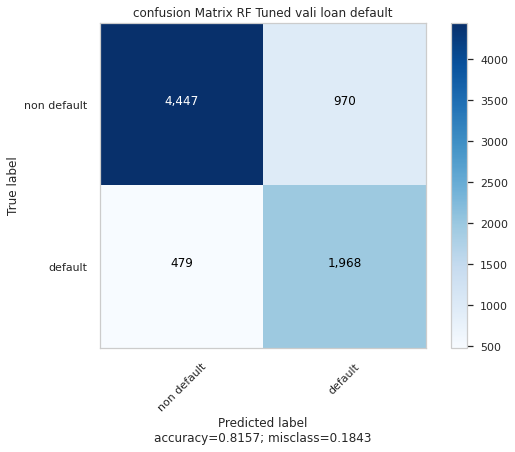

In [101]:
plot_confusion_matrix(cm           = conf_matrixnrftuned,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "confusion Matrix RF Tuned vali loan default")

In [104]:
##### Definetely an improvement  in recall and F1

In [102]:
##### Let's predict on unseen data 

In [103]:
data_unseen_predrf  = rf_credit_risk_init.predict(data_unseen.drop(columns=['default']))

In [104]:
data_unseen['default']

0       1
1       0
2       0
3       0
4       0
       ..
4364    0
4365    0
4366    0
4367    0
4368    0
Name: default, Length: 4369, dtype: int64

In [105]:
##### Classification Report


print(classification_report(data_unseen['default'],data_unseen_predrf))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3004
           1       0.67      0.80      0.73      1365

    accuracy                           0.81      4369
   macro avg       0.78      0.81      0.79      4369
weighted avg       0.83      0.81      0.82      4369



In [106]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(data_unseen['default'],data_unseen_predrf)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8139162279697871


In [107]:
print('F1 Score on unseen dataset : %.3f' % f1_score(data_unseen['default'],data_unseen_predrf))

F1 Score on unseen dataset : 0.729


In [108]:
print('Recall on unseen dataset: %.3f' % recall_score(data_unseen['default'],data_unseen_predrf))

Recall on unseen dataset: 0.801


In [109]:
print('Precision on unseen dataset: %.3f' % precision_score(data_unseen['default'],data_unseen_predrf))

Precision on unseen dataset: 0.669


In [110]:
print('roc auc score on unseen dataset: %.3f' % roc_auc_score(data_unseen['default'],data_unseen_predrf))

roc auc score on unseen dataset: 0.811


In [119]:
rf_credit_risk_init.best_estimator_.feature_importances_

array([0.02948717, 0.32953246, 0.06560801, 0.19993534, 0.19267809,
       0.06309661, 0.01960162, 0.10006071])

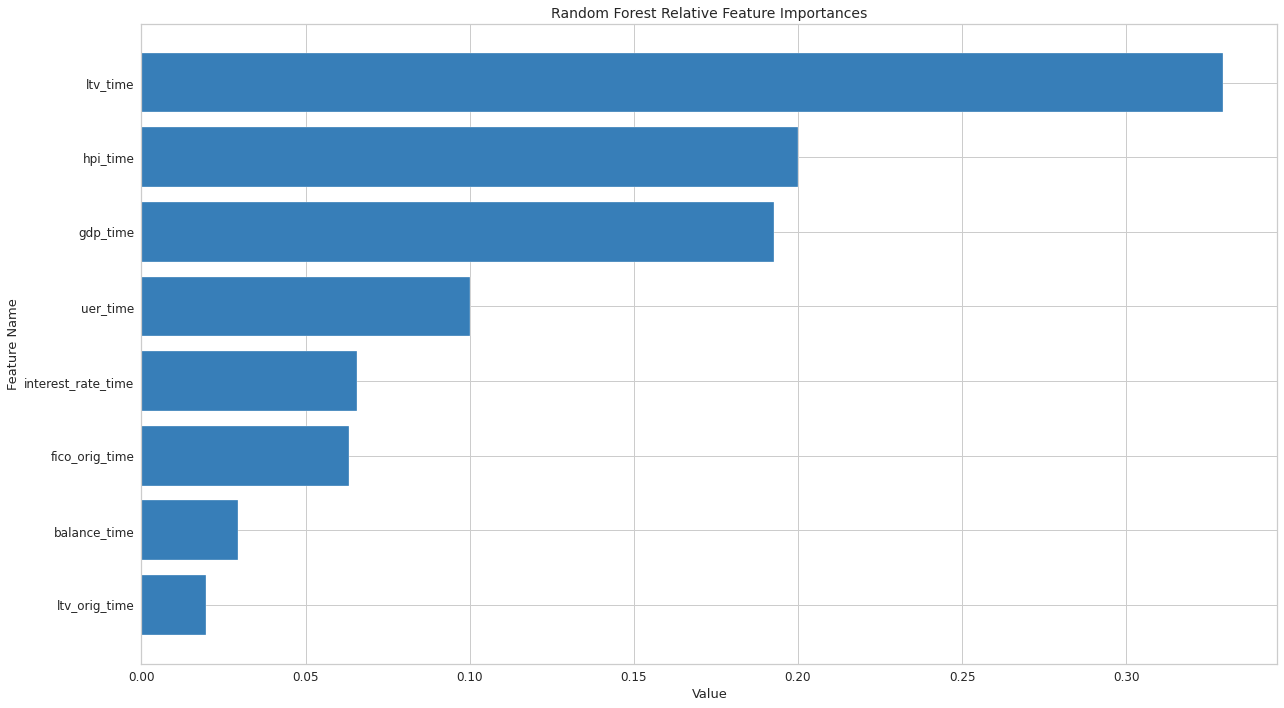

In [121]:
features = X_train.columns
importances = rf_credit_risk_init.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18, 10))
# plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color="#377eb8", align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.xlabel('Value', size=  13)
plt.xticks(size=12)
plt.ylabel('Feature Name', size=  13)
plt.yticks(size=12)
plt.title('Random Forest Relative Feature Importances', size=14)
plt.tight_layout()

plt.show()

In [198]:
##### save estimator

In [199]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/DAAN 888/Project'

In [122]:
rf_credit_risk_init.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=9, max_features='log2', min_samples_leaf=6,
                       min_samples_split=6, n_estimators=1059, random_state=99)

In [94]:
import joblib
joblib.dump(rf_credit_risk_init.best_estimator_, 'rf_credit_risk_best_model1031.pkl')

['rf_credit_risk_best_model1031.pkl']

In [123]:
import joblib
joblib.dump(rf_credit_risk_init.best_estimator_, 'rf_credit_risk_best_model1102.pkl')

['rf_credit_risk_best_model1102.pkl']

In [124]:
# import joblib
# # now you can save it to a file
# joblib.dump(rf_credit_risk_init, 'rf_credit_risk_best_model.pkl') 


In [96]:
# and later you can load it
rf_best = joblib.load('rf_credit_risk_best_model1031.pkl')

In [97]:
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=7, n_estimators=772, random_state=99)

In [125]:
# and later you can load it
rf_best1 = joblib.load('rf_credit_risk_best_model1102.pkl')

In [126]:
rf_best1

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=9, max_features='log2', min_samples_leaf=6,
                       min_samples_split=6, n_estimators=1059, random_state=99)

##### Very good model does not overfit and perform well in unseen dataset (offline evaluation)

##### LightGBM Model

In [32]:
import lightgbm as lgbm
clf = lgbm.LGBMClassifier(objective="binary",class_weight='balanced',n_estimators=1000)

In [33]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=204)

Started at  2021-11-12 13:14:45.888231


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


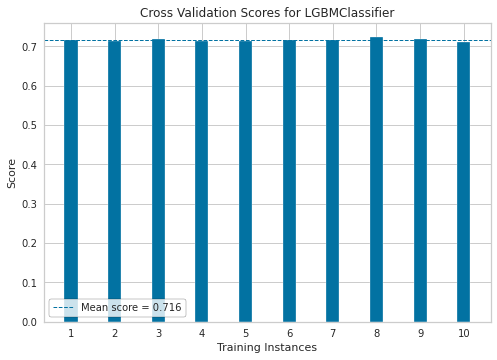

It took: 0.6833333333333333 minutes.


In [34]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

# Fit the data to the visualizer
visualizer = cv_scores(clf, X_train,y_train, cv=cv, scoring=make_scorer(f1_score, average='binary'),
                       n_jobs=-1, seed=121)



end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

In [35]:
clf.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', n_estimators=1000, objective='binary')

In [36]:
# predict the target on the test dataset
predict_test = clf.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8088758901322483


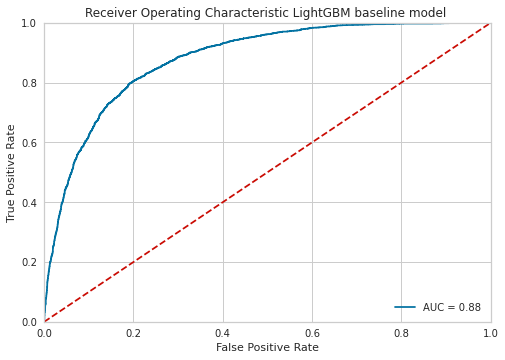

In [45]:
from sklearn.metrics import roc_curve, auc

probs               =  clf.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic LightGBM baseline model ')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5417
           1       0.67      0.77      0.71      2447

    accuracy                           0.81      7864
   macro avg       0.78      0.80      0.79      7864
weighted avg       0.82      0.81      0.81      7864



In [41]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.714


In [42]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.766


In [43]:
print('Precision on on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on on validation dataset: 0.668


In [44]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.797


In [47]:
conf_matrixrlightbaseline = confusion_matrix(y_test,predict_test)

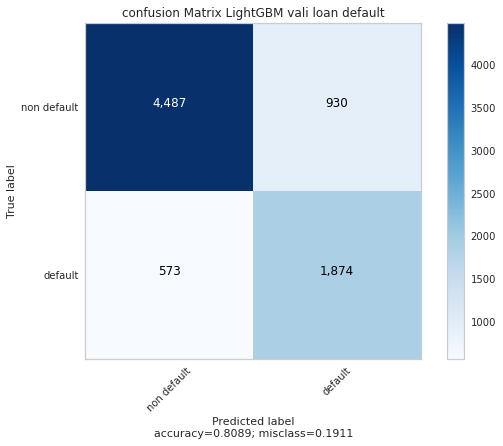

In [48]:
plot_confusion_matrix(cm           = conf_matrixrlightbaseline,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "confusion Matrix LightGBM vali loan default")

###### Improve our LightGBM Baseline model

In [80]:
params = {
    "scale_pos_weight":[1,2,3,4,5,6,7,8,9,10],
    "n_estimators": tune.randint(20, 5000),
    "learning_rate":tune.choice([0.001,0.01,0.02,0.03,0.05,0.07, 0.1 , 0.15, 0.2 , 0.3 , 0.4 , 0.45, 0.5 , 0.55,
       0.6 ,  0.7 , 0.75, 0.8 , 0.9 , 0.95]),
    "num_leaves": tune.randint(20, 120),
    "reg_alpha": [0.5, 1, 1.5, 2, 3,4,5],
    "reg_lambda": [0.5, 1, 1.5, 2, 5],
    "min_split_gain": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "max_depth": [3, 4, 5,6,7,8,9,10,11,12,13,14,15,20,23,25,30,35],
    "bagging_fraction": tune.choice([ 0.2, 0.3, 0.4, 0.5, 0.95])
}

In [81]:
# param_grid = {
#         # "device_type": trial.suggest_categorical("device_type", ['gpu']),
#         "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.95, step=0.1
#         ),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.95, step=0.1
#         ),
#     }

In [82]:
lightgbm = lgbm.LGBMClassifier(objective="binary")

In [84]:
lightgbm_credit_risk_init = TuneSearchCV(
    lightgbm,
params,
    n_trials=25,
    scoring=("f1",),
    refit="f1",
    max_iters=500)

In [85]:
lightgbm_credit_risk_init

TuneSearchCV(estimator=LGBMClassifier(objective='binary'),
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger'>],
             mode='max', n_jobs=-1, n_trials=25,
             param_distributions={'bagging_fraction': <ray.tune.sample.Categorical object at 0x7fc2a5b1d208>,
                                  'learning_rate': <ray.tune.sample.Categorical object at 0x7fc2a5b1d0b8>,
                                  'max_depth': [3, 4, 5...
                                  'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7, 0.8, 0.9],
                                  'n_estimators': <ray.tune.sample.Integer object at 0x7fc2a5b1d080>,
                                  'num_leaves': <ray.tune.sample.Integer object at 0x7fc2a5b1d160>,
                                  'reg_alpha': [0.5, 1, 1.5, 2, 3, 4, 5],
                                  'reg_lambda': [0.5, 1, 1.5, 2, 

In [86]:
import datetime
start = datetime.datetime.now()

lightgbm_credit_risk_init.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

(_Trainable pid=29520) [LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
(_Trainable pid=29560) [LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
(_Trainable pid=29480) [LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
(_Trainable pid=29453) [LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
(_Trainable pid=29542) [LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
(_Trainable pid=29466) [LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
(_Trainable pid=29484) [LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
(_Trainable pid=29

In [87]:
lightgbm_credit_risk_init

TuneSearchCV(estimator=LGBMClassifier(objective='binary'),
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger'>],
             mode='max', n_jobs=-1, n_trials=25,
             param_distributions={'bagging_fraction': <ray.tune.sample.Categorical object at 0x7fc2a5b1d208>,
                                  'learning_rate': <ray.tune.sample.Categorical object at 0x7fc2a5b1d0b8>,
                                  'max_depth': [3, 4, 5...
                                  'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7, 0.8, 0.9],
                                  'n_estimators': <ray.tune.sample.Integer object at 0x7fc2a5b1d080>,
                                  'num_leaves': <ray.tune.sample.Integer object at 0x7fc2a5b1d160>,
                                  'reg_alpha': [0.5, 1, 1.5, 2, 3, 4, 5],
                                  'reg_lambda': [0.5, 1, 1.5, 2, 

In [106]:
# summarize results

print('Best Hyperparameters: %s' % lightgbm_credit_risk_init.best_params_)

print('------------')
print('------------')

print('Best Score: %s' % lightgbm_credit_risk_init.best_score_)

Best Hyperparameters: {'scale_pos_weight': 2, 'n_estimators': 2071, 'learning_rate': 0.05, 'num_leaves': 49, 'reg_alpha': 5.0, 'reg_lambda': 1.0, 'min_split_gain': 0.2, 'max_depth': 30, 'bagging_fraction': 0.4}
------------
------------
Best Score: 0.7262244934659283


In [128]:
#credit_risk.cv_results_

print(lightgbm_credit_risk_init.best_params_)

print('------------')


print(lightgbm_credit_risk_init.best_score_)

{'scale_pos_weight': 2, 'n_estimators': 2071, 'learning_rate': 0.05, 'num_leaves': 49, 'reg_alpha': 5.0, 'reg_lambda': 1.0, 'min_split_gain': 0.2, 'max_depth': 30, 'bagging_fraction': 0.4}
------------
0.7262244934659283


In [129]:
print(lightgbm_credit_risk_init.best_estimator_)

LGBMClassifier(bagging_fraction=0.4, learning_rate=0.05, max_depth=30,
               min_split_gain=0.2, n_estimators=2071, num_leaves=49,
               objective='binary', reg_alpha=5.0, reg_lambda=1.0,
               scale_pos_weight=2)


In [130]:
# predict the target on the test dataset
predict_test = lightgbm_credit_risk_init.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on validation dataset : ', accuracy_test)

accuracy_score on validation dataset :  0.8163784333672431


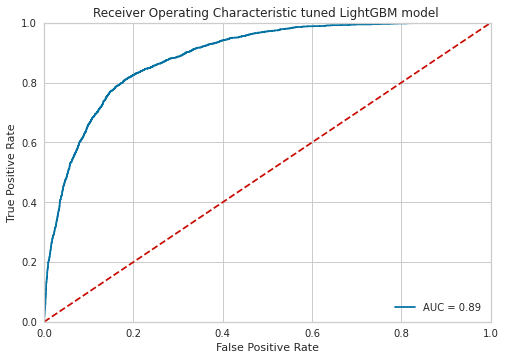

In [137]:
from sklearn.metrics import roc_curve, auc

probs               =  lightgbm_credit_risk_init.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic tuned LightGBM model ')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [132]:
##### Classification Report


print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5417
           1       0.67      0.81      0.73      2447

    accuracy                           0.82      7864
   macro avg       0.79      0.81      0.80      7864
weighted avg       0.83      0.82      0.82      7864



In [133]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.733


In [134]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.670


In [135]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.809


In [136]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.814


In [139]:
conf_matrixrlightlighttuned = confusion_matrix(y_test,predict_test)

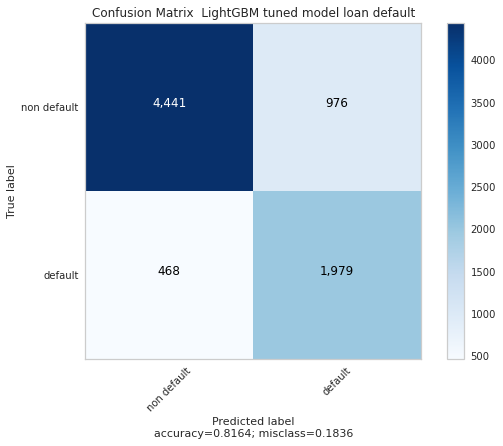

In [140]:
plot_confusion_matrix(cm           = conf_matrixrlightlighttuned,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "Confusion Matrix  LightGBM tuned model loan default")

In [141]:
##### slight improvement  in recall and F1 in comparison to RF

In [142]:
##### Let's predict on unseen data 

In [143]:
data_unseen_predlightgbm  = lightgbm_credit_risk_init.predict(data_unseen.drop(columns=['default']))

In [144]:
##### Classification Report


print(classification_report(data_unseen['default'],data_unseen_predlightgbm))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3004
           1       0.67      0.80      0.73      1365

    accuracy                           0.82      4369
   macro avg       0.79      0.81      0.80      4369
weighted avg       0.83      0.82      0.82      4369



In [145]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(data_unseen['default'],data_unseen_predlightgbm)
print('accuracy_score on unseen dataset : ', accuracy_test)

accuracy_score on unseen dataset :  0.816433966582742


In [146]:
print('F1 Score on unseen dataset : %.3f' % f1_score(data_unseen['default'],data_unseen_predlightgbm))

F1 Score on unseen dataset : 0.732


In [147]:
print('Recall on unseen dataset : %.3f' % recall_score(data_unseen['default'],data_unseen_predlightgbm))

Recall on unseen dataset : 0.804


In [148]:
print('roc auc score on unseen dataset : %.3f' % roc_auc_score(data_unseen['default'],data_unseen_predlightgbm))

roc auc score on unseen dataset : 0.813


In [149]:
print('Precision on unseen dataset : %.3f' % precision_score(data_unseen['default'],data_unseen_predlightgbm))

Precision on unseen dataset : 0.673


In [150]:


print(lightgbm_credit_risk_init.best_params_)

print('------------')


print(lightgbm_credit_risk_init.best_score_)

{'scale_pos_weight': 2, 'n_estimators': 2071, 'learning_rate': 0.05, 'num_leaves': 49, 'reg_alpha': 5.0, 'reg_lambda': 1.0, 'min_split_gain': 0.2, 'max_depth': 30, 'bagging_fraction': 0.4}
------------
0.7262244934659283


In [151]:
lightgbm_credit_risk_init.best_estimator_

LGBMClassifier(bagging_fraction=0.4, learning_rate=0.05, max_depth=30,
               min_split_gain=0.2, n_estimators=2071, num_leaves=49,
               objective='binary', reg_alpha=5.0, reg_lambda=1.0,
               scale_pos_weight=2)

In [188]:
import joblib
joblib.dump(lightgbm_credit_risk_init.best_estimator_, 'lightgbm_credit_risk_best_model1102.pkl')

['lightgbm_credit_risk_best_model1102.pkl']

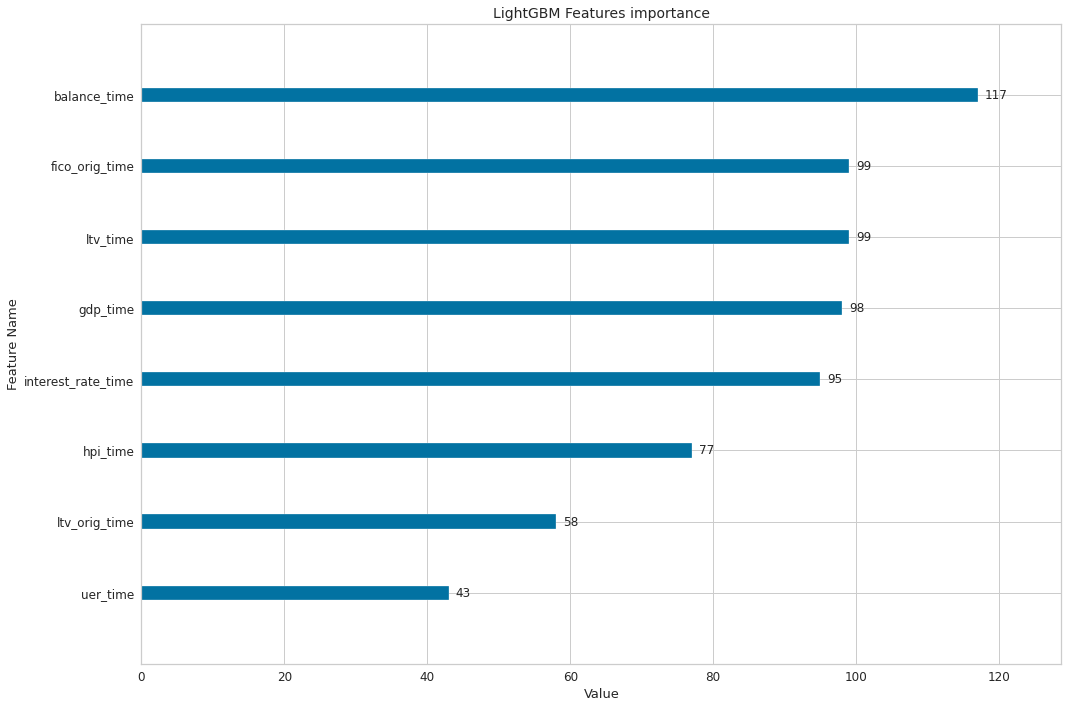

In [189]:
lgbm.plot_importance(lightgbm_credit_risk_init.best_estimator_, figsize=(15, 10))

plt.xlabel('Value', size=  13)
plt.xticks(size=12)
plt.ylabel('Feature Name', size=  13)
plt.yticks(size=12)
plt.title('LightGBM Features importance', size=14)
plt.tight_layout()

##### Lightgbm Optuna

In [260]:
class Optimizer1:
    def __init__(self, metric, trials=300):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_modellightgbm(trial)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        if self.metric == 'f1':
            return f1_score(y_test, preds)
        else:
            return accuracy_score(y_test, preds)
            
    def optimize(self):
        study = optuna.create_study(
            direction="maximize", 
            sampler=self.sampler
        )
        study.optimize(
            self.objective, 
            n_trials=self.trials
        )
        return study
    

In [261]:
import time
start_time = time.time()

def create_modellightgbm(trial):
    boosting_type = "gbdt"
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 200, 10000, step=100)
    bagging_fraction=trial.suggest_uniform('bagging_fraction', 0.1, 1.0)
    bagging_freq= trial.suggest_int('bagging_freq', 0, 20)
    lambda_l1= trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True)
    lambda_l2=trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)
    num_leaves= trial.suggest_int("num_leaves", 2, 256)
    min_child_samples=trial.suggest_int("min_child_samples", 5, 100)
    max_bin=trial.suggest_int("max_bin", 200, 300)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 20,step=1)
    max_depth = trial.suggest_int("max_depth", 1, 40,step=1)
    n_estimators = trial.suggest_int("n_estimators", 1, 6000)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    model =  lgbm.LGBMClassifier(
        boosting_type =boosting_type,
        min_data_in_leaf=min_data_in_leaf,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        max_bin=max_bin,
        scale_pos_weight=scale_pos_weight,
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        objective="binary",
        random_state=666
    )
    return model

optimizer = Optimizer1('f1', 300)
optuna_tudy = optimizer.optimize()
# optuna_params['random_state'] = 666


print("--- %s seconds ---" % (time.time() - start_time)) 

[LightGBM] [Warning] lambda_l1 is set=0.03554041668116747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03554041668116747
[LightGBM] [Warning] bagging_fraction is set=0.8597679785653911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597679785653911
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=3.6569718474944763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6569718474944763
[LightGBM] [Warning] lambda_l1 is set=1.1116793765586611e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1116793765586611e-08
[LightGBM] [Warning] bagging_fraction is set=0.36390529528231064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36390529528231064
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_chi

In [277]:
fig= optuna.visualization.plot_optimization_history(optuna_tudy)

fig.update_layout(template="plotly_white")
fig.show()

In [265]:
# summarize results

print('Best Hyperparameters: %s' % optuna_tudy.best_trial.params)

print('------------')


print('Best Score: %s' % optuna_tudy.best_value)

Best Hyperparameters: {'min_data_in_leaf': 3400, 'bagging_fraction': 0.9096936073147133, 'bagging_freq': 18, 'lambda_l1': 0.23408786967001882, 'lambda_l2': 9.485762134965133e-05, 'num_leaves': 228, 'min_child_samples': 84, 'max_bin': 277, 'scale_pos_weight': 2, 'max_depth': 30, 'n_estimators': 238, 'learning_rate': 0.42778386847594924, 'subsample': 0.8}
------------
Best Score: 0.728579325594251


In [267]:
# display params
hplightgbm = optuna_tudy.best_params
for key, value in hplightgbm.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {optuna_tudy.best_value}")

    min_data_in_leaf : 3400
    bagging_fraction : 0.9096936073147133
        bagging_freq : 18
           lambda_l1 : 0.23408786967001882
           lambda_l2 : 9.485762134965133e-05
          num_leaves : 228
   min_child_samples : 84
             max_bin : 277
    scale_pos_weight : 2
           max_depth : 30
        n_estimators : 238
       learning_rate : 0.42778386847594924
           subsample : 0.8
best objective value : 0.728579325594251


In [269]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

lgbmbest = lgbm.LGBMClassifier(**optuna_tudy.best_params, objective="binary")
lgbmbest.fit(X_train, y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

Started at  2021-11-12 18:20:07.398089
[LightGBM] [Warning] lambda_l1 is set=0.23408786967001882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23408786967001882
[LightGBM] [Warning] bagging_fraction is set=0.9096936073147133, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9096936073147133
[LightGBM] [Warning] lambda_l2 is set=9.485762134965133e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.485762134965133e-05
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
It took: 0.0 minutes.


In [270]:
lgbmbest

LGBMClassifier(bagging_fraction=0.9096936073147133, bagging_freq=18,
               lambda_l1=0.23408786967001882, lambda_l2=9.485762134965133e-05,
               learning_rate=0.42778386847594924, max_bin=277, max_depth=30,
               min_child_samples=84, min_data_in_leaf=3400, n_estimators=238,
               num_leaves=228, objective='binary', scale_pos_weight=2,
               subsample=0.8)

In [271]:
# predict the target on the test dataset
predict_testbest = lgbmbest.predict(X_test)

# Accuracy Score on test dataset
accuracy_test_best = accuracy_score(y_test,predict_testbest)
print('accuracy_score on test dataset : ', accuracy_test_best)

accuracy_score on test dataset :  0.8125635808748728


In [273]:
##### Classification Report


print(classification_report(y_test,predict_testbest))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5417
           1       0.66      0.81      0.73      2447

    accuracy                           0.81      7864
   macro avg       0.78      0.81      0.79      7864
weighted avg       0.83      0.81      0.82      7864



In [274]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_testbest))

F1 Score on validation dataset: 0.728


In [275]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_testbest))

Recall on validation dataset: 0.807


###### XGBOOST Model

In [152]:
from tune_sklearn import TuneSearchCV

In [155]:

xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric=["logloss", "error"],random_state=101)

In [156]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=202)

Started at  2021-11-12 14:18:11.655831


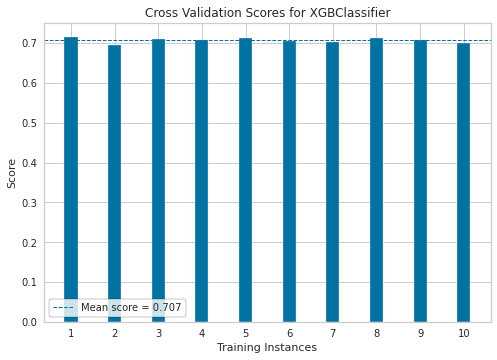

It took: 0.23333333333333334 minutes.


In [157]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

# Fit the data to the visualizer
visualizer = cv_scores(xgb_model, X_train,y_train, cv=cv, scoring='f1',n_jobs=-1, seed=123)



end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

In [158]:
import datetime
start = datetime.datetime.now()

xgb_model.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

It took: 0.016666666666666666 minutes.


In [160]:
# predict the target on the test dataset
predict_test = xgb_model.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8207019328585962


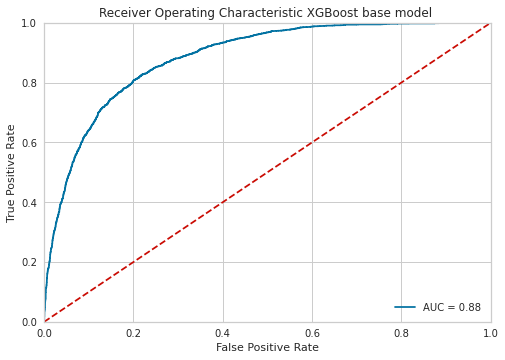

In [168]:
from sklearn.metrics import roc_curve, auc

probs               =  xgb_model.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic XGBoost base model ')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [162]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5417
           1       0.72      0.68      0.70      2447

    accuracy                           0.82      7864
   macro avg       0.79      0.78      0.79      7864
weighted avg       0.82      0.82      0.82      7864



In [164]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.704


In [165]:
print('Precision on validation dataset: : %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: : 0.724


In [166]:
print('Recall on validation dataset:: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset:: 0.685


In [167]:
print('roc auc score on validation dataset:: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset:: 0.783


In [163]:
print('F1 Score: %.3f' % f1_score(y_test,predict_test))

print('Recall: %.3f' % recall_score(y_test,predict_test))

print('Precision : %.3f' % precision_score(y_test,predict_test))

print('roc auc score: %.3f' % roc_auc_score(y_test,predict_test))

F1 Score: 0.704
Recall: 0.685
Precision : 0.724
roc auc score: 0.783


In [171]:
conf_matrixxgbbase = confusion_matrix(y_test,predict_test)

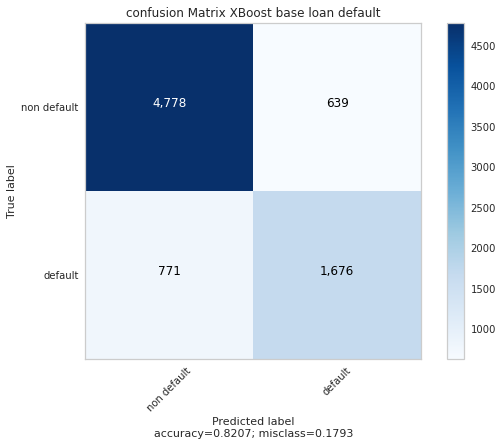

In [172]:
plot_confusion_matrix(cm           = conf_matrixxgbbase ,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "confusion Matrix XBoost base loan default")

##### Improve our XGBClassifies Baseline model

In [173]:
from xgboost import XGBClassifier

In [174]:
from tune_sklearn import TuneSearchCV
from ray import tune

In [175]:
xgb2 = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "error"],
    use_label_encoder=False,
    nthread=5
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

In [176]:
params = {
    "n_estimators": tune.randint(20, 5000),
    "scale_pos_weight":[2,3,4,5,6,79,9,10],
    "min_child_weight": [1, 3,5, 7,10],
    "gamma": [0.5, 1, 1.5, 2, 3,4,5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5,6,7,8,9,10,12,13,15,18,20,25,26,28,30,32,35,40],
    "learning_rate":tune.choice([0.0001,0.001,0.01,0.02,0.03,0.05,0.07, 0.1 , 0.15, 0.2 , 0.3 , 0.4 , 0.45, 0.5 , 0.55,
       0.6 ,  0.7 , 0.75, 0.8 , 0.9 , 0.95]),
}

In [177]:
xgboost_credit_risk_init = TuneSearchCV(
    xgb2,
 param_distributions=params,
    scoring=( "f1"),
    refit="f1",
    max_iters=300)

In [178]:
xgboost_credit_risk_init

TuneSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric=['logloss', 'error'],
                                     gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan...
                                  'learning_rate': <ray.tune.sample.Categorical object at 0x7fc2a58212e8>,
                                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, 13,
                                   

In [179]:
import datetime
start = datetime.datetime.now()

xgboost_credit_risk_init.fit(X_train,y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

It took: 11.983333333333333 minutes.


In [181]:
#### xgboost_credit_risk_init.cv_results_

print(xgboost_credit_risk_init.best_params_)

print('------------')


print(xgboost_credit_risk_init.best_score_)

{'n_estimators': 865, 'scale_pos_weight': 9, 'min_child_weight': 1, 'gamma': 1.5, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 18, 'learning_rate': 0.03}
------------
0.7153658147657281


In [182]:
# summarize results

print('Best Hyperparameters: %s' % xgboost_credit_risk_init.best_params_)

print('------------')
print('------------')

print('Best Score: %s' % xgboost_credit_risk_init.best_score_)

Best Hyperparameters: {'n_estimators': 865, 'scale_pos_weight': 9, 'min_child_weight': 1, 'gamma': 1.5, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 18, 'learning_rate': 0.03}
------------
------------
Best Score: 0.7153658147657281


In [183]:
print(xgboost_credit_risk_init.best_score_)

0.7153658147657281


In [184]:
# predict the target on the test dataset
predict_test =xgboost_credit_risk_init.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on validation dataset : ', accuracy_test)

accuracy_score on validation dataset :  0.8049338758901322


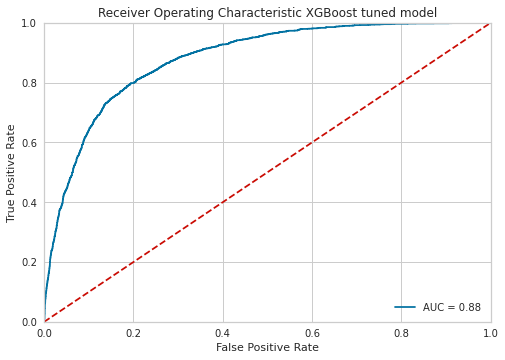

In [191]:
from sklearn.metrics import roc_curve, auc

probs               = xgboost_credit_risk_init.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic XGBoost tuned model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [186]:
##### Classification Report


print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      5417
           1       0.65      0.79      0.72      2447

    accuracy                           0.80      7864
   macro avg       0.77      0.80      0.78      7864
weighted avg       0.82      0.80      0.81      7864



In [187]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.716


In [188]:
print('Recall on validation dataset %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset 0.790


In [189]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.654


In [190]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.801


In [194]:
xgboostconfmatrixtuned = confusion_matrix(y_test,predict_test)

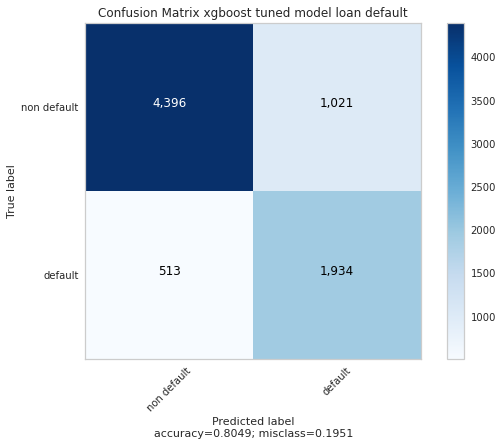

In [196]:
plot_confusion_matrix(cm           = xgboostconfmatrixtuned,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "Confusion Matrix xgboost tuned model loan default")

In [91]:
##### Non improvement in F1 over LGBM vs Random forest

In [123]:
##### Let's predict on unseen data 

In [197]:
data_unseen_predxgboost  = xgboost_credit_risk_init.predict(data_unseen.drop(columns=['default']))

In [198]:
##### Classification Report XGBoost

print(classification_report(data_unseen['default'],data_unseen_predxgboost ))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3004
           1       0.66      0.80      0.72      1365

    accuracy                           0.81      4369
   macro avg       0.78      0.81      0.79      4369
weighted avg       0.82      0.81      0.81      4369



In [209]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(data_unseen['default'],data_unseen_predxgboost)
print('accuracy_score on unseen dataset : ', accuracy_test)

accuracy_score on unseen dataset :  0.8097962920576791


In [210]:
print('F1 Score on unseen dataset: %.3f' % f1_score(data_unseen['default'],data_unseen_predxgboost))

F1 Score on unseen dataset: 0.723


In [211]:
print('Recall on unseen dataset: %.3f' % recall_score(data_unseen['default'],data_unseen_predxgboost))

Recall on unseen dataset: 0.796


In [212]:
print('roc auc score unseen dataset: %.3f' % roc_auc_score(data_unseen['default'],data_unseen_predxgboost))

roc auc score unseen dataset: 0.806


In [213]:
print('Precision on tunseen dataset: %.3f' % precision_score(data_unseen['default'],data_unseen_predxgboost))

Precision on tunseen dataset: 0.663


In [204]:


print(xgboost_credit_risk_init.best_params_)

print('------------')


print(xgboost_credit_risk_init.best_score_)

{'n_estimators': 865, 'scale_pos_weight': 9, 'min_child_weight': 1, 'gamma': 1.5, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 18, 'learning_rate': 0.03}
------------
0.7153658147657281


In [205]:
type(xgboost_credit_risk_init)

tune_sklearn.tune_search.TuneSearchCV

In [206]:
from xgboost import plot_importance

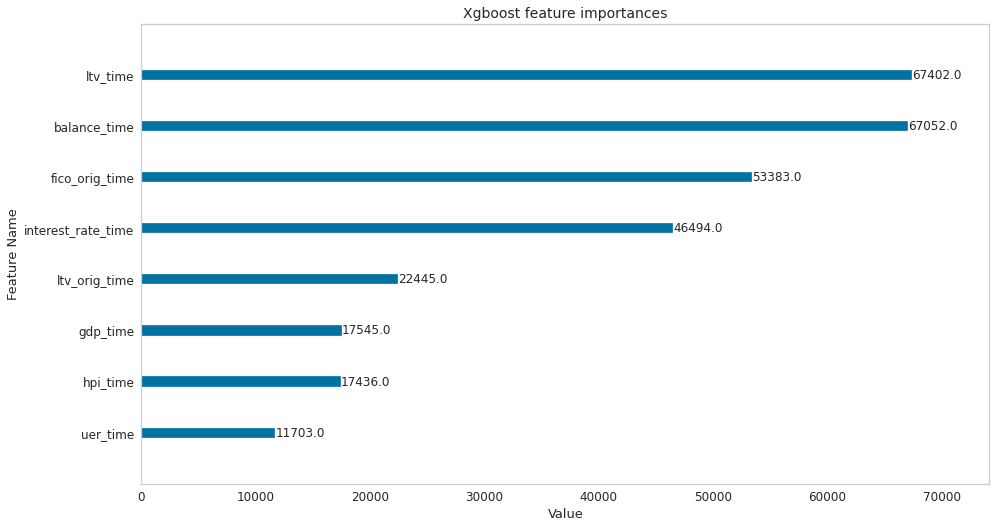

In [208]:
plt.rcParams["figure.figsize"] = (14, 7.5)

plot_importance(xgboost_credit_risk_init.best_estimator_,grid=False,max_num_features=10)

plt.xlabel('Value', size=  13)
plt.xticks(size=12)
plt.ylabel('Feature Name', size=  13)
plt.yticks(size=12)
plt.title('Xgboost feature importances', size=14)
plt.tight_layout()
plt.show()

In [31]:
# plt.rcParams["figure.figsize"] = (42, 18.5)

# _ = xgboost.plot_tree(xgboost_credit_risk_init.best_estimator_)

# plt.tight_layout()
# plt.show()

#####  Optuna Optimization

In [214]:

#  To see optuna progress you need to comment this row
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [54]:
# xgb2 = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric=["logloss", "error"],
#     use_label_encoder=False,
#     nthread=4
#     # tree_method="gpu_hist"  # this enables GPU.
#     # See https://github.com/dmlc/xgboost/issues/2819
# )

In [216]:
class Optimizer:
    def __init__(self, metric, trials=300):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        if self.metric == 'f1':
            return f1_score(y_test, preds)
        else:
            return accuracy_score(y_test, preds)
            
    def optimize(self):
        study = optuna.create_study(
            direction="maximize", 
            sampler=self.sampler
        )
        study.optimize(
            self.objective, 
            n_trials=self.trials
        )
        return study
    

In [217]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier

In [219]:
import time
start_time = time.time()

def create_model(trial):
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 20,step=1)
    max_depth = trial.suggest_int("max_depth", 1, 40,step=2)
    n_estimators = trial.suggest_int("n_estimators", 1, 3000)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 2)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    reg_alpha=trial.suggest_int('reg_alpha', 0, 5)
    reg_lambda=trial.suggest_int('reg_lambda', 0, 5)
    colsample_bynode=trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01)
    model =  XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight= min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        colsample_bynode=colsample_bynode,
        objective="binary:logistic",
        eval_metric=["logloss", "error"],
        use_label_encoder=False,
        random_state=666
    )
    return model

optimizer = Optimizer('f1', 200)
optuna_params = optimizer.optimize()
# optuna_params['random_state'] = 666


print("--- %s seconds ---" % (time.time() - start_time)) 

TypeError: 'Study' object does not support item assignment

In [220]:
optuna_params

In [250]:
print('Number of finished trials:', len(optuna_params.trials))

print('Best trial:', optuna_params.best_trial.params)

Number of finished trials: 200
Best trial: {'scale_pos_weight': 2, 'max_depth': 7, 'n_estimators': 203, 'learning_rate': 0.039052019268505725, 'gamma': 1.954612076722953, 'subsample': 0.6, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 3, 'colsample_bynode': 0.22}


In [257]:
# summarize results

print('Best Hyperparameters: %s' % optuna_params.best_trial.params)

print('------------')


print('Best Score: %s' % optuna_params.best_value)

Best Hyperparameters: {'scale_pos_weight': 2, 'max_depth': 7, 'n_estimators': 203, 'learning_rate': 0.039052019268505725, 'gamma': 1.954612076722953, 'subsample': 0.6, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 3, 'colsample_bynode': 0.22}
------------
Best Score: 0.732662192393736


In [223]:
# display params
hp = optuna_params.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {optuna_params.best_value}")

    scale_pos_weight : 2
           max_depth : 7
        n_estimators : 203
       learning_rate : 0.039052019268505725
               gamma : 1.954612076722953
           subsample : 0.6
    min_child_weight : 3
           reg_alpha : 0
          reg_lambda : 3
    colsample_bynode : 0.22
best objective value : 0.732662192393736


In [252]:
trials_df = optuna_params.trials_dataframe()

In [254]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 100,'display.max_columns',50):
              display(trials_df.head(5))

number     value             datetime_start          datetime_complete  \
0       0  0.659692 2021-11-12 15:17:45.044799 2021-11-12 15:18:17.177068   
1       1  0.676845 2021-11-12 15:18:17.177180 2021-11-12 15:18:36.421912   
2       2  0.695507 2021-11-12 15:18:36.422030 2021-11-12 15:19:03.281183   
3       3  0.691473 2021-11-12 15:19:03.281299 2021-11-12 15:19:49.858817   
4       4  0.675962 2021-11-12 15:19:49.858934 2021-11-12 15:19:56.944497   

                duration  params_colsample_bynode  params_gamma  \
0 0 days 00:00:32.132269                     0.56      1.902916   
1 0 days 00:00:19.244732                     0.32      0.586456   
2 0 days 00:00:26.859153                     0.39      1.818359   
3 0 days 00:00:46.577518                     0.29      0.833424   
4 0 days 00:00:07.085563                     0.48      0.382737   

   params_learning_rate  params_max_depth  params_min_child_weight  \
0              0.727858                33                        9   
1              0.700845                29                        1   
2              0.197503                29                       11   
3              0.547345                25                        8   
4              0.828465                19                       12   

   params_n_estimators  params_reg_alpha  params_reg_lambda  \
0                 2030                 0                  0   
1                  579                 0                  0   
2                 1021                 1                  3   
3                 2457                 0                  4   
4                  462                 5                  5   

   params_scale_pos_weight  params_subsample     state  
0                       15               0.5  COMPLETE  
1                        5               0.8  COMPLETE  
2                        1               0.9  COMPLETE  
3                       18               0.8  COMPLETE  
4                        2               0.6  COMPLETE

In [256]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 100,'display.max_columns',50):
              display(trials_df.tail(10))

number     value             datetime_start          datetime_complete  \
190     190  0.732662 2021-11-12 16:32:30.012094 2021-11-12 16:32:31.979689   
191     191  0.732090 2021-11-12 16:32:31.979901 2021-11-12 16:32:33.974797   
192     192  0.726257 2021-11-12 16:32:33.974998 2021-11-12 16:32:35.985746   
193     193  0.714971 2021-11-12 16:32:35.985960 2021-11-12 16:32:36.871566   
194     194  0.683899 2021-11-12 16:32:36.871784 2021-11-12 16:32:38.666532   
195     195  0.730575 2021-11-12 16:32:38.666740 2021-11-12 16:32:41.681709   
196     196  0.721106 2021-11-12 16:32:41.681927 2021-11-12 16:32:50.563508   
197     197  0.730698 2021-11-12 16:32:50.563728 2021-11-12 16:32:52.746006   
198     198  0.710029 2021-11-12 16:32:52.746226 2021-11-12 16:32:54.993134   
199     199  0.715918 2021-11-12 16:32:54.993343 2021-11-12 16:33:02.155865   

                  duration  params_colsample_bynode  params_gamma  \
190 0 days 00:00:01.967595                     0.22      1.954612   
191 0 days 00:00:01.994896                     0.22      1.964912   
192 0 days 00:00:02.010748                     0.23      1.998905   
193 0 days 00:00:00.885606                     0.22      1.949366   
194 0 days 00:00:01.794748                     0.19      1.963574   
195 0 days 00:00:03.014969                     0.22      1.917137   
196 0 days 00:00:08.881581                     0.27      1.912280   
197 0 days 00:00:02.182278                     0.23      1.921626   
198 0 days 00:00:02.246908                     0.22      1.917728   
199 0 days 00:00:07.162522                     0.25      1.929810   

     params_learning_rate  params_max_depth  params_min_child_weight  \
190              0.039052                 7                        3   
191              0.044518                 7                        3   
192              0.016179                 7                        3   
193              0.049751                 9                        3   
194              0.001376                 7                        4   
195              0.042354                 9                        3   
196              0.036873                 9                        3   
197              0.029389                 7                        3   
198              0.046298                 7                        3   
199              0.080638                 9                        4   

     params_n_estimators  params_reg_alpha  params_reg_lambda  \
190                  203                 0                  3   
191                  207                 0                  3   
192                  204                 0                  3   
193                   67                 0                  3   
194                  188                 0                  3   
195                  256                 0                  3   
196                  638                 0                  3   
197                  225                 0                  3   
198                  238                 0                  3   
199                  532                 0                  3   

     params_scale_pos_weight  params_subsample     state  
190                        2               0.6  COMPLETE  
191                        2               0.6  COMPLETE  
192                        2               0.6  COMPLETE  
193                        3               0.6  COMPLETE  
194                        1               0.6  COMPLETE  
195                        2               0.6  COMPLETE  
196                        3               0.6  COMPLETE  
197                        2               0.6  COMPLETE  
198                        1               0.6  COMPLETE  
199                        2               0.6  COMPLETE

In [264]:
from optuna.visualization import plot_contour

# plot_contour(optuna_params)

In [262]:
optuna.visualization.plot_parallel_coordinate(optuna_params)

In [224]:
optuna.visualization.plot_optimization_history(optuna_params)

In [225]:
optuna_params.best_params

{'scale_pos_weight': 2,
 'max_depth': 7,
 'n_estimators': 203,
 'learning_rate': 0.039052019268505725,
 'gamma': 1.954612076722953,
 'subsample': 0.6,
 'min_child_weight': 3,
 'reg_alpha': 0,
 'reg_lambda': 3,
 'colsample_bynode': 0.22}

In [39]:
1632.55/60

27.209166666666665

In [38]:
optuna_params

{'scale_pos_weight': 4,
 'max_depth': 22,
 'n_estimators': 76,
 'learning_rate': 0.05749779561449684,
 'gamma': 0.23885359406856999,
 'subsample': 0.9,
 'min_child_weight': 8,
 'reg_alpha': 1,
 'reg_lambda': 0,
 'colsample_bynode': 0.43000000000000005,
 'random_state': 666}

In [39]:
1200.79/60

20.013166666666667

In [40]:
optuna_params

{'scale_pos_weight': 4,
 'max_depth': 22,
 'n_estimators': 76,
 'learning_rate': 0.05749779561449684,
 'gamma': 0.23885359406856999,
 'subsample': 0.9,
 'min_child_weight': 8,
 'reg_alpha': 1,
 'reg_lambda': 0,
 'colsample_bynode': 0.43000000000000005,
 'random_state': 666}

In [40]:
optuna_params

{'scale_pos_weight': 9,
 'max_depth': 20,
 'n_estimators': 26,
 'learning_rate': 0.1128577423459426,
 'gamma': 0.11095376089207946,
 'subsample': 0.6,
 'min_child_weight': 1,
 'random_state': 666}

In [226]:
import datetime
start = datetime.datetime.now()

start_time = dt.datetime.now()
print("Started at ", start_time)

clfbest = XGBClassifier(**optuna_params.best_params, objective="binary:logistic",
        eval_metric=["logloss", "error"],)
clfbest.fit(X_train, y_train)

end = datetime.datetime.now()
process_time = end - start
print("It took: " + str(process_time.seconds/60) + " minutes.")

Started at  2021-11-12 17:12:50.707561
It took: 0.016666666666666666 minutes.


In [227]:
# predict the target on the test dataset
predict_test = clfbest.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8151068158697864


In [228]:
# predict the target on the test dataset
predict_test = clfbest.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8151068158697864


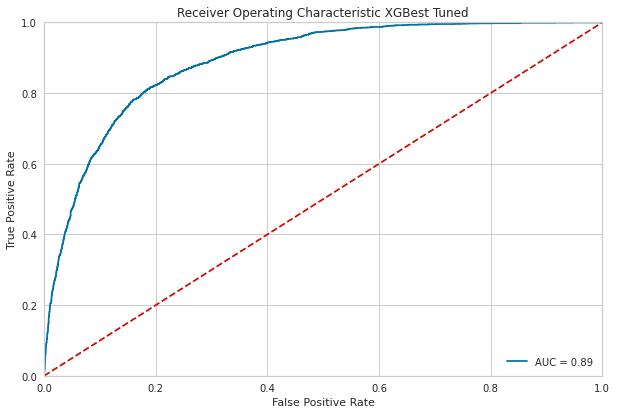

In [229]:
from sklearn.metrics import roc_curve, auc

probs               =  clfbest.predict_proba(X_test)
preds               = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc             = auc(fpr, tpr)
plt.figure(figsize=(10, 6.5))
plt.title('Receiver Operating Characteristic XGBest Tuned')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [230]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5417
           1       0.67      0.80      0.73      2447

    accuracy                           0.82      7864
   macro avg       0.79      0.81      0.79      7864
weighted avg       0.83      0.82      0.82      7864



In [231]:
##### Classification Report


from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5417
           1       0.67      0.80      0.73      2447

    accuracy                           0.82      7864
   macro avg       0.79      0.81      0.79      7864
weighted avg       0.83      0.82      0.82      7864



In [232]:
print('F1 Score on validation dataset: %.3f' % f1_score(y_test,predict_test))

F1 Score on validation dataset: 0.729


In [233]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.800


In [235]:
print('Recall on validation dataset: %.3f' % recall_score(y_test,predict_test))

Recall on validation dataset: 0.800


In [236]:
print('roc auc score on validation dataset: %.3f' % roc_auc_score(y_test,predict_test))

roc auc score on validation dataset: 0.811


In [237]:
print('Precision on validation dataset: %.3f' % precision_score(y_test,predict_test))

Precision on validation dataset: 0.670


In [238]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [239]:
conf_matrixrxg2t = confusion_matrix(y_test,predict_test)

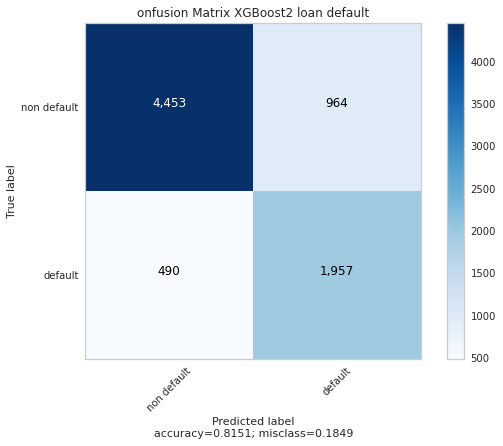

In [240]:
plot_confusion_matrix(cm           = conf_matrixrxg2t,
                      normalize    = False,
                      target_names = ['non default', 'default'],
                      title        = "onfusion Matrix XGBoost2 loan default")

##### Unseen data

In [241]:
data_unseen_predxgboost1  = clfbest.predict(data_unseen.drop(columns=['default']))

In [242]:
##### Classification Report XGBoost

print(classification_report(data_unseen['default'],data_unseen_predxgboost1 ))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3004
           1       0.67      0.80      0.73      1365

    accuracy                           0.82      4369
   macro avg       0.79      0.81      0.80      4369
weighted avg       0.83      0.82      0.82      4369



In [243]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(data_unseen['default'],data_unseen_predxgboost1 )
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8166628519111925


In [244]:
print('F1 Score on test dataset : %.3f' % f1_score(data_unseen['default'],data_unseen_predxgboost1))

F1 Score on test dataset : 0.732


In [245]:
print('Recall on test dataset: %.3f' % recall_score(data_unseen['default'],data_unseen_predxgboost1))

Recall on test dataset: 0.802


In [246]:
print('roc auc score test dataset: %.3f' % roc_auc_score(data_unseen['default'],data_unseen_predxgboost1))

roc auc score test dataset: 0.813


In [247]:
print('Precision on test dataset: %.3f' % precision_score(data_unseen['default'],data_unseen_predxgboost1))

Precision on test dataset: 0.673


In [248]:
from xgboost import plot_importance

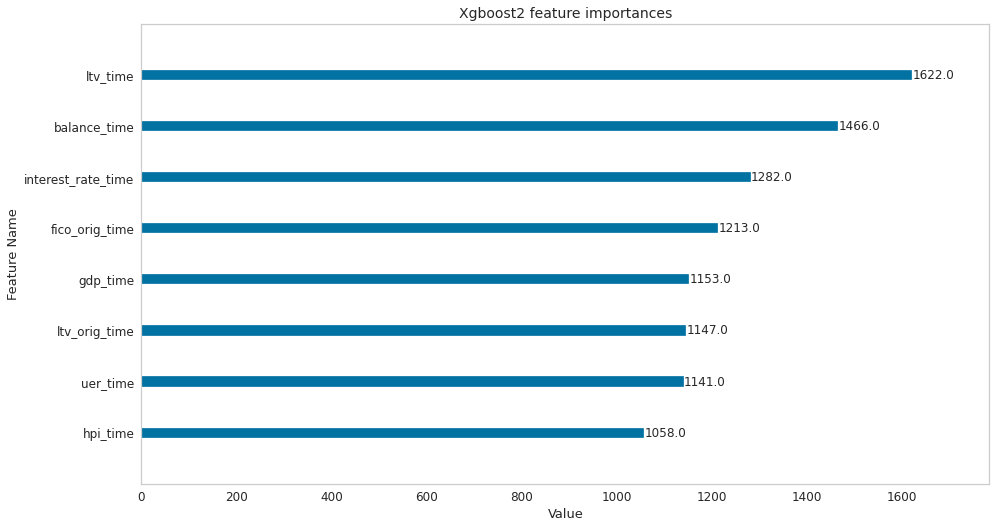

In [249]:
plt.rcParams["figure.figsize"] = (14, 7.5)

plot_importance(clfbest,grid=False,max_num_features=10)

plt.xlabel('Value', size=  13)
plt.xticks(size=12)
plt.ylabel('Feature Name', size=  13)
plt.yticks(size=12)
plt.title('Xgboost2 feature importances', size=14)
plt.tight_layout()
plt.show()